In [1]:
%load_ext autoreload
%cd ..

/Users/trippgordon/Desktop/Code/sonic/NoisyGAN


In [2]:
%autoreload 2
%reload_ext autoreload
!pwd
from core import *

/Users/trippgordon/Desktop/Code/sonic/NoisyGAN


# Messing with cppn

In [3]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,LeakyReLU,\
                                    Flatten,Dense,Reshape,Conv2DTranspose,\
                                    Input, Activation, BatchNormalization
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Adam

from ddsp.core import midi_to_hz
from ddsp.spectral_ops import F0_RANGE, LD_RANGE

In [108]:
class CPPN_f0(Model):

    def __init__(self,
                 n_nodes = 32,
                 n_hidden = 3,
                 activation = 'tanh',
                 t_scale=1,
                 z_scale=0.1,
                 z_dim=16):

        super().__init__()
        self.t_scale = t_scale
        self.z_scale = z_scale
        self.z_dim = z_dim

        weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)
#         weight_init = tf.keras.initializers.Ones()

        # input layers
        self.time_input = Dense(n_nodes,
                         input_shape=(1000, 1),
                         kernel_initializer=weight_init,
                         use_bias=False)

        self.z_input = Dense(n_nodes, input_shape=(1000, self.z_dim))

        # fc model
        self.fc_model = Sequential()
        for i in range(n_hidden):
            self.fc_model.add(BatchNormalization())
            self.fc_model.add(Activation(activation))
            self.fc_model.add(Dense(n_nodes, kernel_initializer=weight_init))
        self.fc_model.add(Dense(1, kernel_initializer=weight_init))
        self.fc_model.add(BatchNormalization())
        self.fc_model.add(Activation("sigmoid"))
        self.fc_model.add(Activation("sigmoid"))

    def call(self,inputs=None):
        z = self.z_scale * tf.random.uniform((1, self.z_dim),minval=-1.0, maxval=1.0) # (1, z_dim)
        z = tf.linalg.matmul(tf.ones((1000,1)), z) # (1000, zdim)
        Uz = self.z_input(z)

        t = self.t_scale * tf.reshape(tf.range(-1,1,delta=(1/500), dtype='float32'), (1,1000,1))
        Ut = self.time_input(t)

        U = Ut + Uz
        f0_scaled = self.fc_model(U)
        return f0_scaled

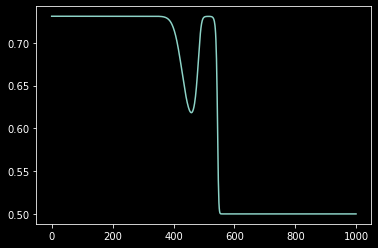

In [119]:
cppn_f0 = CPPN_f0(n_nodes = 32, n_hidden = 3, t_scale=1, z_scale=1, z_dim=8, activation="tanh")
f0_scaled = cppn_f0(None)
plt.plot(f0_scaled[0])

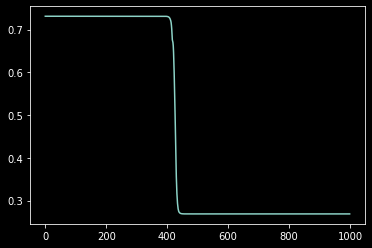

In [77]:
f0_scaled = cppn_f0(None)
plt.plot(f0_scaled[0])